In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import xgboost as xgb

# sklearn
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

In [3]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Data Preparation

In [4]:
df = pd.read_csv('Data/CreditScoring.csv')
df.columns = df.columns.str.lower()
df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658


Categorical variables are represented by numbers. For converting, we'll use the following map (extracted from [Part1_CredScoring_Processing.R](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)). It's code in R which we'll translate to Pandas.

In [5]:
# transform numerical values to categorical
status_values = { 
    1: 'ok', 
    2:'default',
    0: 'unk'
}
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

# map number to string
df.status = df.status.map(status_values)
df.home = df.home.map(home_values)
df.marital = df.marital.map(marital_values)
df.records = df.records.map(records_values)
df.job = df.job.map(job_values)

df.head(2)

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658


In [6]:
boolean_mask = df.dtypes == 'object'

categorical = list(df.dtypes[boolean_mask].index)
printest('categorical' , categorical )

numerical  = list(df.dtypes[~boolean_mask].index)
printest('numerical' , numerical )

df[categorical].nunique()

categorical : 
 ['status', 'home', 'marital', 'records', 'job'] 

numerical : 
 ['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'] 



status     3
home       7
marital    6
records    2
job        5
dtype: int64

In [7]:
# Stats for the dataset
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


The maximum value is 99999999, and indicate missing values. Let's replace it by `NaN`: 

In [8]:
for i in ['income', 'assets', 'debt']:
    df[i] = df[i].replace(to_replace = 99999999, value = np.nan )

df.isna().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

For the target variable is need to exclude the status with  value 'unk'.

In [9]:
# tilde (~) operator is a bit-wise NOT operator
df = df[ ~df.status.isin(['unk'])]
print(df.status.value_counts())

ok         3200
default    1254
Name: status, dtype: int64


Now is necessary to split the dataset, handle missing values and use one-hot encode to prepare the feature matrix $\mathbf{X}$ and target variable vector $\mathbf{y}$. For this is defined a function to handle the dataset:

In [10]:
df.shape

(4454, 14)

In [11]:
def prepare_data(df):

    # split in train (60%), validation (20%) and test (20%)
    # 0.8 and 0.2
    df_train_full, df_test = train_test_split(df, test_size = 0.2,  random_state = 11)
    # 0.75 * 0.8 = 0.6 and  0.25 * 0.8 = 0.2 
    df_train, df_val = train_test_split(df_train_full, test_size = 0.25 ,  random_state = 11)

    # y is “True/1” if the client defaulted and “False/0” otherwise
    y_train = (df_train.status == 'default').values
    y_val = (df_val.status == 'default').values

    del df_train['status']
    del df_val['status']

    df_train = df_train.fillna(0)
    df_val = df_val.fillna(0)

    dict_train = df_train.to_dict(orient = 'records')
    dict_val = df_val.to_dict(orient = 'records')

    dv = DictVectorizer(sparse = False)
    X_train = dv.fit_transform(dict_train)
    X_val = dv.transform(dict_val)


    return X_train, X_val, y_train, y_val, dv

X_train, X_val, y_train, y_val, dv = prepare_data(df)

# Decision Trees - Theory

Consider a hypothetical dataset, denoted as $\mathbf{D}$, consisting of multiple attributes and a target variable:

$$\mathbf{D} =
\left( \begin{array}{c|cccc|c}
~    &X_{0}&X_{1}&\cdots & X_{d}  & \mathbf{y}\\
\hline
\mathbf{x}_{1} &1& x_{11}& \cdots&x_{1d}&y_1 \\
\vdots&\vdots&\vdots&\ddots&\vdots&\vdots\\
\mathbf{x}_{n}&1&x_{n1}&\cdots&x_{nd}&y_n
\end{array} \right).$$

This matrix $\mathbf{D}$ represents our dataset. Each row corresponds to a unique client and each column (aside from the last one) corresponds to a specific attribute or feature of that client. $X_0$ is a column of ones, often called the bias or intercept term. We assume the attribute $X_j$ can be either numeric or categorical, and there are $k$ distinct classes, such that elements of $\mathbf{y} = (y_1, \cdots, y_i, \cdots, y_n)^T$ can take values $y_i \in {c_1, \cdots, c_k}$.

A decision tree is a recursive model that employs partition-based methods to predict the class $\hat{y}_i$ for each instance $\mathbf{x}_i$. The process starts with splitting the data into two subsets, denoted as $\mathbf{D}_Y$ and $\mathbf{D}_N$, by an axis-parallel hyperplane. The subsets are further divided recursively, aiming to achieve a state where the majority of points within a subset belong to the same class.

Let's now illustrate the method of using an axis-parallel hyperplane to divide our dataset into smaller subsets. A hyperplane refers to candy a plane equation for dimension higher then three, in three dimension we would have a  plane, and in two dimension we would have a line. The equation for the hyperplane is the same equation used in linear regression, with the difference that here is an inequality:

$$h(\mathbf{X}) = \mathbf{w}^T\mathbf{X}\leq 0$$

Here, the inequality expresses that we're interested in a region bounded by the hyperplane in a d-dimensional space with axes $X_{1}, \cdots,X_{j}, \cdots, X_{d}$ (excluding $X_{0}$, which isn't an axis). The weights in this case, $\mathbf{w} = (w_0, 0, \cdots, 1,\cdots, 0)^T$, are different from those in linear regression. Only the bias term $w_0$ and the jth element are non-zero, giving us:


$$w_0X_0 + 1.X_j\leq 0$$

if we call the bias term as $v = -w_0$ and knowing that $X_0$ is a unit vector, then

$$X_j\leq \mathbb{I}v$$

where selecting different values for the offset $v$ gives different hyperplanes along the dimension $X_j$. The decision or split point $X_j\leq v$ thus splits the input data space (denoted as $\mathcal{R}$) into two regions, $\mathcal{R}_Y$ (satisfying the decision) and $\mathcal{R}_N$ (not satisfying the decision).

Each split of $\mathcal{R}$ into $\mathcal{R}_Y$ and $\mathcal{R}_N$ induces a binary partition of the corresponding data points in $\mathbf{D}$. Specifically, a split point of the form $X_j\leq v$ induces the data partition

$$\mathbf{D}_Y =  \{\mathbf{x} \in \mathbf{D}| x_j \leq v\}$$
$$\mathbf{D}_N =  \{\mathbf{x} \in \mathbf{D}| x_j > v\}$$

where $\mathbf{D}_Y$ denotes the subset of data points that lie in region $\mathcal{R}_Y$ and $\mathbf{D}_N$ denotes the subset of data points that lie in $\mathcal{R}_N$.

The attribute $X_j$ in the dataset $\mathbf{D}$ could be either numeric or categorical. For numeric attributes, the split points take the form $X_j\leq v$ for some value $v$ within the attribute's range. For categorical attributes, the split points are of the form $X_j \in \mathbf{V}$ for some subset $\mathbf{V}$ of the attribute's domain.

### **Numerical**

When dealing with numerical values, an effective strategy is to consider only the midpoints between two successive distinct values of an attribute $X$ in the sample space $\mathbf{D}$. Representing these midpoints as ${v_1, \cdots, v_m}$, such that $v_1 < \cdots < v_m$, each split point $X_j\leq v$ requires us to estimate the probability mass function (PMF):

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \leq v) $$

$$P(c_i|\mathbf{D}_N) = P(c_i|X > v)$$


By applying Bayes' theorem, we can compute these conditional probabilities. Here we are interested in the probability of the class $c_i$ happening given the partition dataset $\mathbf{D}_N$ or $\mathbf{D}_Y$. Using Bayes rule for the partition  $\mathbf{D}_Y$:

​$$P(c_i|X \geq v) = \frac{P(X \geq v|c_i) \cdot P(c_i)}{P(X \geq v)} = \frac{P(X \geq v|c_i) \cdot P(c_i)}{\sum_k P(X \geq v|c_k)P(c_k)} $$



**prior probability $P(c_i)$**

The prior probability for each class in dataset $\mathbf{D}$ can be estimated as follows:

$$P(c_i) = \frac{n_i}{n}$$

where $n_i$ is the total number of points in $\mathbf{D}$ of class $c_i$ and $n$ is the total number of points in $\mathbf{D}$.

**Conditional probability $P(X \geq v|c_i)$**

The conditional probability helps understand the relationship between two sets of events. Here we have the set $X \geq v$ of points from $\mathbf{D}$ that has attribute values bigger then $v$, and the set of points from $\mathbf{D}$ witch has class $c_i$ and we desire to find the relationship between this two sets. For the conditional probability can be calculated as:

$$P(X \geq v|c_i) = \frac{P((X \geq v) \cap c_i)}{P(X \geq v)} = \frac{N_{vi}}{n_i}$$

where $N_{vi}$ is the total number of points in the intersection set of the two events $X \geq v$  and $c_i$. This means that we are looking at points from $\mathbf{D}$ that has attribute values greater then v and with class $c_i$, and $n_i$ is the total number of points in $\mathbf{D}$ of class $c_i$.


Finally, the bayes rule can be written as 

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \leq v) =  \frac{P(X \geq v|c_i) \cdot P(c_i)}{\sum_k P(X \geq v|c_k)P(c_k)}$$

$$P(c_i|\mathbf{D}_Y) = \frac{N_{vi}}{n} \frac{\sum_k N_{vk}}{n}$$

then the PMF for partition $\mathbf{D}_Y$ is

$$P(c_i|\mathbf{D}_Y) = \frac{N_{vi}}{\sum_k N_{vk}}$$

and for $\mathbf{D}_N$ can be calculated as $P(c_i|\mathbf{D}_N) = 1 - P(c_i|\mathbf{D}_Y)$:

$$P(c_i|\mathbf{D}_N) = \frac{n_i - N_{vi}}{\sum_k (n_k - N_{vk})}$$

### **Categorical**

For categorical values, we can use a similar process to derive the PMFs for the partition datasets $\mathbf{D}_N$ and $\mathbf{D}_Y$. In this case, $n_{vi}$ represents the number of points in the dataset $\mathbf{D}$, with attribute value $v$ for attribute X and class $c_i$. Thus, we get:

$$P(c_i|\mathbf{D}_Y) = P(c_i|X \in V) =  \frac{\sum_{v \in V} n_{vi}}{\sum_k \sum_{v \in V} n_{vk}}$$

and

$$P(c_i|\mathbf{D}_N) = P(c_i|X \notin V) =  \frac{\sum_{v \notin V} n_{vi}}{\sum_k \sum_{v \notin V} n_{vk}}$$

where $n_{vi}$ is the number of points in the dataset $\mathbf{D}$, with attribute value $v$ for attribute X and class $c_i$.

### **Evaluating split points**

For a numerical or categorical attribute split point, defined as $X\leq v$ or $X \in \mathbf{V}$, we require a scoring criterion to effectively separate the different class labels ${c_1, \cdots, c_k}$.

**Information Gain**

Information gain measures the reduction of disorder or uncertainty in a system. The goal is to use entropy as a metric for each partition, favoring a lower entropy if the partition is pure (i.e., most points have the same class label). Conversely, if class labels are mixed with no majority class, a partition has higher entropy.

The entropy of a set of labeled points $\mathbf{D}$ is defined as:

$$H(\mathbf{D}) = - \sum^{k}_{i=1} P(c_i| \mathbf{D}) \log{P(c_i| \mathbf{D})}$$

where $P(x_i| \mathbf{D})$ is the probability of class $c_i$ in $\mathbf{D}$, and $k$ is the number of classes.

When a split point partitions $\mathbf{D}$ into $\mathbf{D}_Y$ and $\mathbf{D}_N$, we define the split entropy as the weighted entropy of each of the resulting partitions:

$$H(\mathbf{D}_Y, \mathbf{D}_N) = \frac{n_Y}{n}H(\mathbf{D}_Y) + \frac{n_N}{n}H(\mathbf{D}_N)$$

where $n = |\mathbf{D}|$ is the number of points in $\mathbf{D}$, and $n_Y$ and $n_N$ are the number of points in $\mathbf{D}_Y$ and $\mathbf{D}_N$, respectively.

The information gain for a given split point, representing the reduction in overall entropy, is defined as:

$$\text{Grain}(\mathbf{D},\mathbf{D}_Y, \mathbf{D}_N) = H(\mathbf{D}) - H(\mathbf{D}_Y, \mathbf{D}_N)$$

A higher information gain corresponds to a greater reduction in entropy, thus signaling a better split point. Therefore, we can score each split point and select the one that provides the highest information gain.


**Gini Index**

The Gini index, another common purity measure for a split point, is defined as:

$$G(\mathbf{D}) = 1 - \sum_{i=1}^{k} P(c_i| \mathbf{D})^2$$

Higher Gini index values signify more disorder, while lower values indicate a higher order with respect to the class labels. The weighted Gini index of a split point is then defined as:

$$G(\mathbf{D}_Y, \mathbf{D}_N) = \frac{n_Y}{n}G(\mathbf{D}_Y) + \frac{n_N}{n}G(\mathbf{D}_N)$$


**CART**

Another useful measure is the CART, defined as:

$$\text{CART}(\mathbf{D}_Y, \mathbf{D}_N) = 2 \frac{n_Y}{n}\frac{n_N}{n} \sum_{i = 1}^k |P(c_i| \mathbf{D}_Y )  -P(c_i| \mathbf{D}_N)$$

This metric maximizes the difference between the class probability mass function for the two partitions; a higher CART value implies a better split point.



# Decision Trees

In [12]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

Credit risk scoring is a binary classification problem, and for cases like this, AUC (Area Under the Curve) is one of the best evaluation metrics. AUC refers to the area under the ROC (Receiver Operating Characteristic) curve. The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings:

$$(FPR, TPR) = \bigg(\frac{ \text{FP} }{\text{TN}+\text{FP} },\frac{\text{TP}}{\text{TP} +\text{FN}} \bigg)$$


where FP denotes the number of False Positives, TN stands for True Negatives, TP symbolizes True Positives, and FN represents False Negatives. The threshold in this context is not a parameter of the model but a cut-off value to decide which category (positive or negative) a particular instance falls into, based on the predicted probabilities produced by the model.

By varying the threshold from 0 to 1, each unique predicted probability is considered as a potential threshold and the corresponding TPR and FPR are calculated. These pairs of TPR and FPR form the ROC curve. The AUC provides an aggregate measure of the model performance across all possible thresholds. Thus, in this way, we can visualize and evaluate the performance of the classification model under different threshold settings.

In [13]:
def plot_ROC(fpr, tpr):
    plt.figure(figsize=(5, 5))

    plt.plot(fpr, tpr, color='black', linestyle='solid')
    plt.plot(fpr, tpr, color='black', linestyle='dashed')
    plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

    plt.xlim([-0.02, 1.02])
    plt.ylim([-0.02, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC curve')

    plt.show()

Thresholds : 
 [2. 1. 0.] 

AUC : 
 1.0 



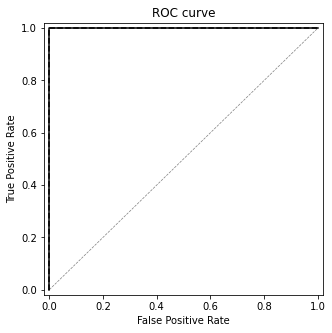

In [14]:
y_pred = dt.predict_proba(X_train)[:,1]

fpr_train, tpr_train, t_train = roc_curve(y_train, y_pred)
auc_train = roc_auc_score(y_train, y_pred)

printest("Thresholds", t_train)
printest("AUC", auc_train)

plot_ROC(fpr_train, tpr_train)


In [15]:
y_pred

array([1., 1., 0., ..., 0., 0., 0.])

Our analysis suggests we are encountering overfitting. To corroborate this, we can apply the same model to our validation dataset. This is likely to demonstrate that the model, in its learning process, has essentially memorized the outcomes of the training data. Yet, when faced with the validation set, it failed. It lacks the ability to generalize from the patterns it learned from the training data. This is a classic manifestation of overfitting, highlighting the need for a careful balance between learning and generalization in model training.

Thresholds : 
 [0.         0.16401274 1.        ] 

AUC : 
 0.6518339347557579 



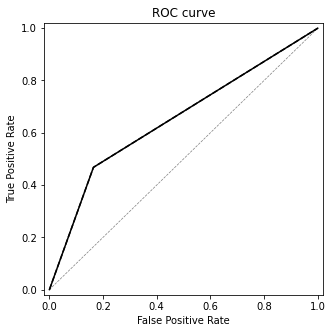

In [16]:
y_pred = dt.predict_proba(X_val)[:,1]
fpr_val, tpr_val, t_val = roc_curve(y_val, y_pred)
auc_val = roc_auc_score(y_val, y_pred)

printest("Thresholds", fpr_val)
printest("AUC", auc_val)


plot_ROC(fpr_val, tpr_val)

We have multiple ways to control the complexity of a tree. One option is to restrict
its size: we can specify the ``max_depth`` parameter, which controls the maximum number
of levels. The more levels a tree has, the more complex rules it can learn.

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: False
|   |--- job=partime >  0.50
|   |   |--- class: True
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: True
|   |--- seniority >  6.50
|   |   |--- class: False



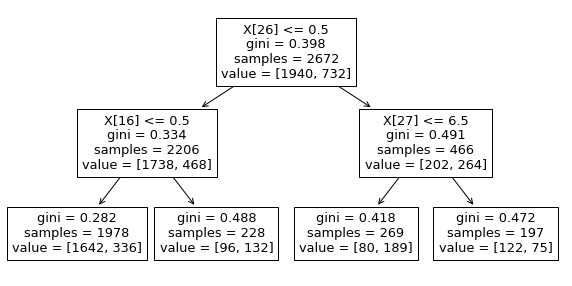

In [17]:
dt = DecisionTreeClassifier(max_depth = 2)
dt.fit(X_train, y_train)

tree_text = export_text(dt, feature_names = dv.feature_names_)
print(tree_text)

# draw the decision tree 
fig, ax = plt.subplots(figsize=(10, 5))  
plot_tree(dt, ax=ax)
plt.show()

In [18]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
printest('train auc', auc)
y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
printest('validation auc', auc)

train auc : 
 0.7054989859726213 

validation auc : 
 0.6685264343319367 



## Parameter tuning for Decision Tree

We aim to find the optimal values for the parameters ``max_depth`` and ``min_samples_leaf``.

- The ``max_depth`` parameter indicates the maximum depth of the tree. It is the longest path from the tree root to a leaf. t's a measure of the maximum amount of overfitting that can occur. Lower values will make the model more conservative and prevent overfitting by ensuring that it doesn't learn the training data too well, but can potentially underfit if the depth is set too low.

- The ``min_samples_leaf`` parameter is the minimum number of samples required to be at a leaf node. This parameter is very effective in smoothing the model, especially in regression. When this parameter is small, leaves can have very few samples, resulting in a model that captures a lot of detail and possibly noise. When this parameter is large, the tree becomes more constrained as it has to consider more samples at each leaf.

In [19]:
def parameter_tune_dt( x, 
                    y, 
                    x_val, 
                    y_val, 
                    max_depths: list = [1, 2, 3, 4, 5, 6, 10, 15, 20], 
                    max_samples: list = [1, 5, 10, 15, 20, 50, 100, 200]):

    def run_model(x, y, x_val, y_val, max_depth = None, min_samples_leaf = 1):
        dt = DecisionTreeClassifier(max_depth = max_depth, min_samples_leaf= min_samples_leaf)
        dt.fit(x, y)
        y_pred = dt.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        return y_pred, auc

    results = []
    for depth in max_depths:
        y_pred, auc = run_model( x, y, x_val, y_val, max_depth = depth)
        results.append({'max_depth': depth, 'auc': auc })

    df_depth = pd.DataFrame(results)
    df_depth = df_depth.sort_values(by='auc', ascending=False)
    max_depth = df_depth.max_depth[:3].to_list()

    results = {'sample_leaf': max_samples}
    results.update({f'depth={int(d)}|auc': [] for d in max_depth})

    for d in max_depth:
        for s in max_samples:
            y_pred, auc = run_model(x , y, x_val, y_val, max_depth = d, min_samples_leaf = s)
            results[f'depth={int(d)}|auc'].append(auc)

    df_best_parameters = pd.DataFrame(results).set_index('sample_leaf')
    df_depth = df_depth.set_index('max_depth')

    return df_depth, df_best_parameters

In [20]:
df_depth , df_parameter = parameter_tune_dt(X_train, y_train, X_val, y_val)
display(df_depth)
display(df_parameter)

,auc
max_depth,
5,0.766938
4,0.761283
6,0.743839
3,0.738908
10,0.673113
2,0.668526
15,0.665078
20,0.645026
1,0.605864


,depth=5|auc,depth=4|auc,depth=6|auc
sample_leaf,,,
1,0.766496,0.761283,0.747481
5,0.767755,0.761283,0.762330
10,0.761809,0.761283,0.777803
15,0.771806,0.763726,0.785695
20,0.773537,0.760910,0.773337
50,0.766753,0.753457,0.770289
100,0.763384,0.755937,0.776434
200,0.759073,0.747260,0.768267


In [21]:
df_parameter.max()

depth=5|auc    0.773537
depth=4|auc    0.763726
depth=6|auc    0.785695
dtype: float64

As we can se the best parameters for the decision three are ``max_depth = 6`` and ``min_sample_leaf  = 15``. Let’s use them to train the final model:

AUC Decision Tree : 
 0.7856948245380349 



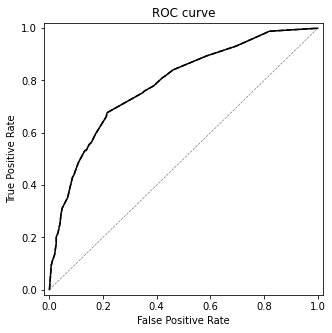

In [22]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
printest('AUC Decision Tree', roc_auc_score(y_val, y_pred_dt))

fpr, tpr, t = roc_curve(y_val, y_pred_dt)
plot_ROC(fpr, tpr)

# Random Forest

In [23]:
def parameter_tune_rf(  x, 
                        y, 
                        x_val, 
                        y_val, 
                        n_estimators = range(10, 221, 20),
                        max_depths: list = [4, 5, 6, 10, 15, 20], 
                        min_samples: list = [3, 5, 10, 15, 20, 50, 100]):

    def run_model(x, y, x_val, y_val, n_estimators = 100, max_depth = None, min_samples_leaf = 1):
        dt = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, min_samples_leaf = min_samples_leaf, random_state=1)
        dt.fit(x, y)
        y_pred = dt.predict_proba(x_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        return y_pred, auc
    
    results = {'n_trees': n_estimators}
    results.update({f'depth={int(d)}|auc': [] for d in max_depths})
    for d in max_depths:
        for i in n_estimators:
            y_pred, auc = run_model( x, y, x_val, y_val, n_estimators = i, max_depth = d)
            results[f'depth={int(d)}|auc'].append(auc)
    dt_depths = pd.DataFrame(results).set_index('n_trees') 
    best_depth_str = dt_depths.max().idxmax()
    best_depth = int(best_depth_str.split('=')[1].split('|')[0])

    results = {'n_trees': n_estimators}
    results.update({f'sample_leaf={int(d)}|auc': [] for d in min_samples})
    for l in min_samples:
        for i in n_estimators:
            y_pred, auc = run_model( x, y, x_val, y_val, n_estimators = i, max_depth = best_depth, min_samples_leaf = l )
            results[f'sample_leaf={int(l)}|auc'].append(auc)
    dt_leafs = pd.DataFrame(results).set_index('n_trees') 
    best_leafs_str = dt_leafs.max().idxmax()
    best_leafs= int(best_leafs_str.split('=')[1].split('|')[0])

    best_parameters = {'max_depth':best_depth, 'min_samples_leaf': best_leafs}

    return dt_depths, dt_leafs, best_parameters

In [24]:
dt_depths, dt_leafs, best_parameters = parameter_tune_rf(X_train, y_train, X_val, y_val)

,depth=4|auc,depth=5|auc,depth=6|auc,depth=10|auc,depth=15|auc,depth=20|auc
n_trees,,,,,,
10,0.778036,0.787699,0.800641,0.791365,0.794704,0.776307
30,0.795812,0.800305,0.813334,0.811584,0.810128,0.813443
50,0.795655,0.799878,0.811481,0.817058,0.813364,0.814905
70,0.797538,0.802251,0.811215,0.820230,0.814061,0.814154
90,0.798627,0.803616,0.812614,0.819843,0.815420,0.814106
110,0.800523,0.806626,0.814121,0.822646,0.816422,0.816918
130,0.802630,0.808054,0.815344,0.824517,0.817914,0.818199
150,0.801727,0.807219,0.815901,0.824166,0.818474,0.818090
170,0.801836,0.806965,0.815332,0.824632,0.819128,0.817363


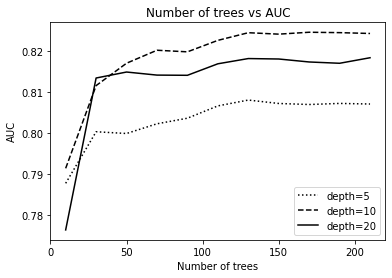

In [25]:
display(dt_depths)

plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(dt_depths.index, dt_depths['depth=5|auc'], label='depth=5', color='black', linestyle='dotted')
plt.plot(dt_depths.index, dt_depths['depth=10|auc'], label='depth=10', color='black', linestyle='dashed')
plt.plot(dt_depths.index, dt_depths['depth=20|auc'], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()


,sample_leaf=3|auc,sample_leaf=5|auc,sample_leaf=10|auc,sample_leaf=15|auc,sample_leaf=20|auc,sample_leaf=50|auc,sample_leaf=100|auc
n_trees,,,,,,,
10,0.810758,0.812947,0.809665,0.815535,0.804788,0.798891,0.791722
30,0.822531,0.817802,0.822319,0.816924,0.812256,0.803562,0.802006
50,0.822937,0.821266,0.822380,0.816537,0.813249,0.805378,0.798222
70,0.821538,0.822198,0.819383,0.816991,0.812063,0.804712,0.798101
90,0.823282,0.822470,0.820369,0.816537,0.812620,0.806226,0.800044
110,0.823403,0.824547,0.819831,0.816809,0.813049,0.805947,0.799542
130,0.824414,0.825286,0.820515,0.817736,0.813933,0.806202,0.801437
150,0.824850,0.825031,0.820339,0.817603,0.813340,0.805978,0.800074
170,0.824959,0.824868,0.819903,0.817584,0.813376,0.805172,0.798845


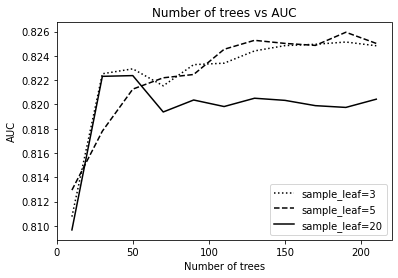

In [26]:
display(dt_leafs)

plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(dt_depths.index, dt_leafs['sample_leaf=3|auc'], label='sample_leaf=3', color='black', linestyle='dotted')
plt.plot(dt_depths.index, dt_leafs['sample_leaf=5|auc'], label='sample_leaf=5', color='black', linestyle='dashed')
plt.plot(dt_depths.index, dt_leafs['sample_leaf=10|auc'], label='sample_leaf=20', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

As we can se the best parameters for the Random forest are ``max_depth = 10``, ``min_sample_leaf  = 5`` and ``n_estimators=200``. Let’s use them to train the final model:

AUC Random Forest : 
 0.8253826499721489 

AUC Decision Tree : 
 0.7856948245380349 



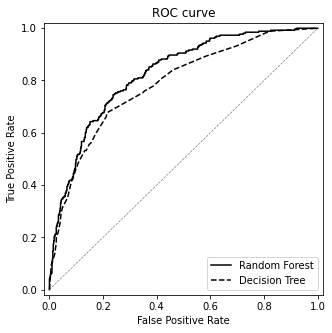

In [27]:
# colocar legenda
rf = RandomForestClassifier(n_estimators=200, max_depth = best_parameters['max_depth'], min_samples_leaf = best_parameters['min_samples_leaf'], random_state=1)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_val)[:, 1]
printest('AUC Random Forest' , roc_auc_score(y_val, y_pred_rf))
printest('AUC Decision Tree' , roc_auc_score(y_val, y_pred_dt))


plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='black', linestyle='solid', label = 'Random Forest')

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='black', linestyle='dashed', label = 'Decision Tree')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()


# XGBoost: Extreme Gradient Boosting

In [45]:
# Data structure that is designed for efficiency and speed in XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

# XGBoost will print out performance metrics for each dataset in watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

# Save evaluation metrics
evals_result = {}

# Some default parameters for XGBoost
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 6,
    'seed': 1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100, 
                  evals = watchlist, evals_result = evals_result, verbose_eval = 10)

[0]	train-auc:0.86300	val-auc:0.76818
[10]	train-auc:0.95002	val-auc:0.81558
[20]	train-auc:0.97316	val-auc:0.81775
[30]	train-auc:0.98772	val-auc:0.81787
[40]	train-auc:0.99456	val-auc:0.81387
[50]	train-auc:0.99688	val-auc:0.81128
[60]	train-auc:0.99889	val-auc:0.80801
[70]	train-auc:0.99944	val-auc:0.80732
[80]	train-auc:0.99985	val-auc:0.80677
[90]	train-auc:0.99992	val-auc:0.80637
[99]	train-auc:0.99998	val-auc:0.80546


In gradient boosting, the number of trees (also called ``num_boost_round``) directly corresponds to the iteration number. For example, after 10 iterations (or "boosting rounds"), you have 10 trees in your ensemble.

So, if we have a list of AUC scores for each iteration, the number of trees corresponding to each AUC score is simply the index of the score in the list plus one.

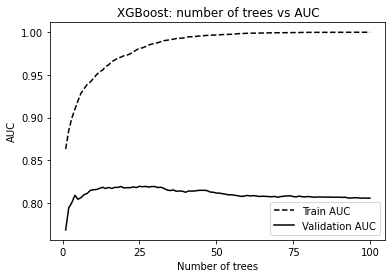

In [46]:
# auc scores for each set
train_auc = evals_result['train']['auc']
val_auc = evals_result['val']['auc']
# number of trees
n_trees = list(range(1, len(train_auc) + 1))


plt.figure(figsize=(6, 4))

plt.plot(n_trees, train_auc, color='black', linestyle='dashed', label='Train AUC')
plt.plot(n_trees, val_auc, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

plt.show()

The effect of the number of trees on the AUC from train and validation sets. This behavior is expected: in boosting, every next model tries to fix the mistakes from
the previous step, so the score is always improving.
For the validation score, however, this is not the case. It goes up initially but then
starts to decrease. This is the effect of overfitting: our model becomes more and more
complex until it simply memorizes the entire training set.

# hyperparameters tuning

A hyperparameter is a type of parameter, external to the model, set before the learning process begins. It’s tunable and can directly affect how well a model performs.

- ``max_depth``: The maximum depth per tree. This is the maximum number of nodes from the root to the farthest leaf of a tree. Deeper trees can model more complex relationships by adding more nodes, but they also risk overfitting.
  - The value must be an integer greater than 0. Default is 6.

- **learning_rate** ($\eta$): The learning rate determines the step size at each iteration while your model optimizes toward its objective. A low learning rate makes computation slower, and requires more rounds to achieve the same reduction in residual error as a model with a high learning rate. But it optimizes the chances to reach the best optimum.
  - The value must be between 0 and 1. Default is 0.3.

- ``num_boost_round``: This is the number of boosting rounds or trees to build. It's equivalent to the number of iterations in gradient boosting. More rounds lead to a more complex model, but too many rounds can lead to overfitting.

- ``min_child_weight``: If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process gives up further partitioning. This controls overfitting as well. The larger, the more conservative the algorithm will be.

- ``subsample``: Corresponds to the fraction of observations (the rows) to subsample at each step. By default it is set to 1 meaning that we use all rows. This is similar to the subsampling made in the Random Forest algorithm, where at each step the model are choosing a random subset of the dataset to prevent overfitting. 

### Naive tunning